# Hysteresis Loops Fitting

In [1]:
import sys
sys.path.append('../../')
# sys.path.append("/home/ferroelectric/m3_learning/m3_learning/src")
sys.path.append('../../src')

In [2]:
%load_ext autoreload
%autoreload 2

import h5py
import pyUSID as usid

from src.m3_learning.be.processing import fit_loop_function, loop_lsqf
from m3_learning.be.loop_fitter import loop_fitting_function_torch
from m3_learning.viz.layout import subfigures

import numpy as np

from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.viz.printing import printer
from m3_learning.be.viz import Viz
from m3_learning.be.dataset import BE_Dataset
from m3_learning.be.nn import SHO_fit_func_nn, SHO_Model
from m3_learning.nn.Fitter1D.Fitter1D import Multiscale1DFitter, Model
# from m3_learning.nn.Fitter1D.Fitter1D_new import Multiscale1DFitter, Model
from m3_learning.be.filters import clean_interpolate

printing = printer(basepath = './Figures/')


set_style("printing")
random_seed(seed=42)

%matplotlib inline

printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


## Loads data

In [3]:
# Specify the filename and the path to save the file
filename = 'data_raw_unmod.h5'
save_path = "./Data"

data_path = save_path + "/" + filename

# instantiate the dataset object
dataset = BE_Dataset(data_path)

# print the contents of the file
dataset.print_be_tree()

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values
/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices
├ R

## Performs SHO fits

In [4]:
h5_loop_fit, h5_loop_group = dataset.LSQF_Loop_Fit()

Consider calling test() to check results before calling compute() which computes on the entire dataset and writes results to the HDF5 file

Note: Loop_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000" (11 members)>]

Note: Loop_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000" (11 members)>]
Returned previously computed results at /Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000

Note: Loop_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000" (11 members)>]
Returned previously computed res

/home/alk224/miniconda3/envs/alibek/lib/python3.9/site-packages/pyUSID/io/hdf_utils/simple.py:888: UserWarning: A dataset named: Guess_Loop_Parameters already exists in group: /Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000
  warn('A dataset named: {} already exists in group: {}'.format(dset_name, h5_group.name))
/home/alk224/miniconda3/envs/alibek/lib/python3.9/site-packages/pyUSID/io/hdf_utils/simple.py:888: UserWarning: A dataset named: Fit_Loop_Parameters already exists in group: /Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000
  warn('A dataset named: {} already exists in group: {}'.format(dset_name, h5_group.name))


## Visualize LSQF fit results

In [5]:
# insatiate the visualization object
image_scalebar = [2000, 500, "nm", "br"]

# instantiate the dataset object
dataset = BE_Dataset(data_path)

BE_viz = Viz(dataset, printing, verbose=True, 
             SHO_ranges = [(0,1.5e-4), (1.31e6, 1.33e6), (-300, 300), (-np.pi, np.pi)], 
             image_scalebar = image_scalebar)

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values


In [6]:
# BE_viz.hysteresis_comparison(data = ['LSQF'])

## Neural Network Fits

In [7]:
dataset.loop_param_scaler

StandardScaler()

In [8]:
data, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values


In [9]:
dataset.hysteresis_scaler

In [10]:
dataset.hysteresis_scaler.mean

-1.0685155e-05

In [11]:
np.mean(data)

4.582935e-08

In [12]:
dataset.hysteresis_scaler.std

7.083071e-05

In [13]:
voltage.shape

(96, 4)

In [15]:
data[:,:,0,:].shape

(60, 60, 96)

In [17]:
from m3_learning.be.loop_fitter import loop_fitting_function_torch
from m3_learning.optimizers.TrustRegion import TRCG
import torch.optim as optim


data, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)
V = np.swapaxes(np.atleast_2d(dataset.get_voltage), 0, 1).astype(np.float64)


model_ = Multiscale1DFitter(loop_fitting_function_torch, # function 
#                             voltage[:,0].squeeze(), # x data
                            V.squeeze(),
                            1, # input channels
                            9, # output parameters
                            dataset.loop_param_scaler,
                            loops_scaler=dataset.hysteresis_scaler)

# instantiate the model
model = Model(model_, dataset, training=True, model_basename="SHO_Fitter_original_data")

from sklearn.model_selection import train_test_split


X_train, X_test = train_test_split(data.reshape(-1,96), test_size=0.2, random_state=42, shuffle=True)

X_train = np.atleast_3d(X_train)

optimizer = {
    "name": "TRCG", 
    "optimizer": TRCG,
    "closure_size": 1,
    "cgopttol": 1e-3,
    "c0tr": 0.2,
    "c1tr": 0.25,
    "c2tr": 0.75,
    "t1tr": 0.75,
    "t2tr": 2.0,
    "radius_max": 5.0,  
    "radius_initial": 1.0,
    "radius" : 1.0,
    "device": "cuda",
    "ADAM_epochs": 20}


train = True

if train:
    # fits the model
    model.fit(
        X_train,
        4096,
        optimizer='Adam',
        epochs = 200,
    )
else:
    model.load(
        "/home/ferroelectric/m3_learning/m3_learning/papers/2023_Rapid_Fitting/Trained Models/SHO Fitter/SHO_Fitter_original_data_model_epoch_5_train_loss_0.0449272525189978.pth"
    )

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values
Using GPU A100-SXM4-40GB
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


/home/alk224/miniconda3/envs/alibek/lib/python3.9/site-packages/torch/autograd/__init__.py:200: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1151.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Adam
epoch : 1/200, recon loss = 1.75758058
--- 1.475682020187378 seconds ---
Epoch 1, Learning Rate: 0.003
Adam
epoch : 2/200, recon loss = 1.17007620
--- 0.0678567886352539 seconds ---
Epoch 2, Learning Rate: 0.003
Adam
epoch : 3/200, recon loss = 0.86504295
--- 0.5830576419830322 seconds ---
Epoch 3, Learning Rate: 0.003
Adam
epoch : 4/200, recon loss = 0.66959043
--- 0.08510017395019531 seconds ---
Epoch 4, Learning Rate: 0.003
Adam
epoch : 5/200, recon loss = 0.50061267
--- 0.06328511238098145 seconds ---
Epoch 5, Learning Rate: 0.003
Adam
epoch : 6/200, recon loss = 0.35337813
--- 0.06044816970825195 seconds ---
Epoch 6, Learning Rate: 0.003
Adam
epoch : 7/200, recon loss = 0.42598609
--- 0.06057906150817871 seconds ---
Epoch 7, Learning Rate: 0.003
Adam
epoch : 8/200, recon loss = 0.33915983
--- 0.05836844444274902 seconds ---
Epoch 8, Learning Rate: 0.003
Adam
epoch : 9/200, recon loss = 0.30433433
--- 0.07340049743652344 seconds ---
Epoch 9, Learning Rate: 0.003
Adam
epoch : 1

Adam
epoch : 76/200, recon loss = 0.05566594
--- 0.0534968376159668 seconds ---
Epoch 76, Learning Rate: 0.003
Adam
epoch : 77/200, recon loss = 0.05541550
--- 0.05340766906738281 seconds ---
Epoch 77, Learning Rate: 0.003
Adam
epoch : 78/200, recon loss = 0.05546971
--- 0.06661057472229004 seconds ---
Epoch 78, Learning Rate: 0.003
Adam
epoch : 79/200, recon loss = 0.05581208
--- 0.056108951568603516 seconds ---
Epoch 79, Learning Rate: 0.003
Adam
epoch : 80/200, recon loss = 0.05495334
--- 0.05954599380493164 seconds ---
Epoch 80, Learning Rate: 0.003
Adam
epoch : 81/200, recon loss = 0.05449436
--- 0.054105281829833984 seconds ---
Epoch 81, Learning Rate: 0.003
Adam
epoch : 82/200, recon loss = 0.05435557
--- 0.054433584213256836 seconds ---
Epoch 82, Learning Rate: 0.003
Adam
epoch : 83/200, recon loss = 0.05398965
--- 0.06641745567321777 seconds ---
Epoch 83, Learning Rate: 0.003
Adam
epoch : 84/200, recon loss = 0.05380880
--- 0.05710339546203613 seconds ---
Epoch 84, Learning Ra

Adam
epoch : 150/200, recon loss = 0.04861735
--- 0.05588245391845703 seconds ---
Epoch 150, Learning Rate: 0.003
Adam
epoch : 151/200, recon loss = 0.04850466
--- 0.05794835090637207 seconds ---
Epoch 151, Learning Rate: 0.003
Adam
epoch : 152/200, recon loss = 0.04842507
--- 0.05583024024963379 seconds ---
Epoch 152, Learning Rate: 0.003
Adam
epoch : 153/200, recon loss = 0.04836009
--- 0.055442094802856445 seconds ---
Epoch 153, Learning Rate: 0.003
Adam
epoch : 154/200, recon loss = 0.04828366
--- 0.05296158790588379 seconds ---
Epoch 154, Learning Rate: 0.003
Adam
epoch : 155/200, recon loss = 0.04821618
--- 0.05274343490600586 seconds ---
Epoch 155, Learning Rate: 0.003
Adam
epoch : 156/200, recon loss = 0.04818933
--- 0.05583357810974121 seconds ---
Epoch 156, Learning Rate: 0.003
Adam
epoch : 157/200, recon loss = 0.04810340
--- 0.05546212196350098 seconds ---
Epoch 157, Learning Rate: 0.003
Adam
epoch : 158/200, recon loss = 0.04804454
--- 0.05253410339355469 seconds ---
Epoch

In [18]:
import torch
X_train = torch.atleast_3d(torch.tensor(X_train))


train_pred_recon, train_pred_params_scaled, train_pred_params = model.predict(
    X_train,
    1024,
    translate_params=False
)

In [19]:
train_pred_recon.shape
train_pred_params_scaled.shape
train_pred_params.shape

torch.Size([11520, 9])

In [20]:
X_train[1000].shape

torch.Size([96, 1])

In [21]:
voltage.shape

(96, 4)

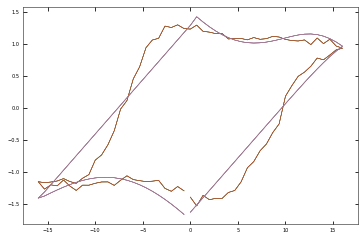

In [24]:
i = np.random.randint(0, X_train.shape[0])

import matplotlib.pyplot as plt
plt.plot(voltage, X_train[i])
plt.plot(voltage, np.atleast_2d(train_pred_recon[i]))

## Plot a Random Example of the fit

In [58]:
# insatiate the visualization object
image_scalebar = [2000, 500, "nm", "br"]

BE_viz = Viz(dataset, printing, verbose=True, 
             SHO_ranges = [(0,1.5e-4), (1.31e6, 1.33e6), (-300, 300), (-np.pi, np.pi)], 
             image_scalebar = image_scalebar)

self = BE_viz

In [59]:
dataset.get_state

{'resampled': False,
 'raw_format': 'complex',
 'fitter': 'LSQF',
 'scaled': False,
 'output_shape': 'pixels',
 'measurement_state': 'all',
 'resampled_bins': 165,
 'LSQF_phase_shift': None,
 'NN_phase_shift': None,
 'noise': 0,
 'loop_interpolated': False}

In [60]:
out, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values


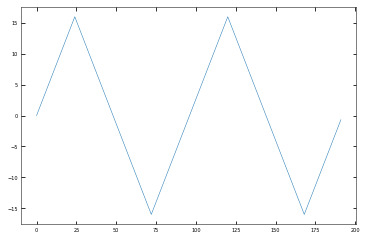

In [61]:
plt.plot(dataset.dc_voltage)

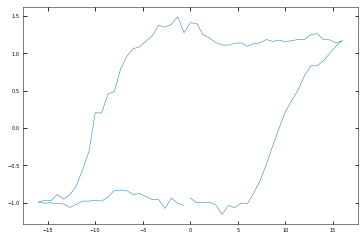

In [62]:
import matplotlib.pyplot as plt

a = np.random.randint(0,60,(1))
b = np.random.randint(0,60,(1))


plt.plot(voltage[:,0].squeeze(), out[a,b,0].squeeze())

In [63]:
hys, bias = dataset.get_hysteresis()

hys_2 = clean_interpolate(hys, axis=3)

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values


In [ ]:
def find_non_finite_indices(arr):
    non_finite_mask = ~np.isfinite(arr)
    indices = np.argwhere(non_finite_mask)
    return indices

In [ ]:
hys.shape

In [ ]:
find_non_finite_indices(hys)

In [ ]:
a

In [ ]:
import matplotlib.pyplot as plt

a = np.random.randint(0,60,(1))
b = np.random.randint(0,60,(1))


plt.plot(hys[a[0],b[0],0])
plt.plot(hys_2[a[0],b[0],0])

In [12]:
def hysteresis_fit(self, 
                   voltage, 
                   datasets, 
                   original = True,
                   row = None, 
                   col = None,
                   cycle = None):
    
    if row is None:
        row = np.random.randint(0, self.dataset.num_rows, 1)
        
    if col is None:
        col = np.random.randint(0, self.dataset.num_cols, 1)
        
    if cycle is None:
        cycle = np.random.randint(0, self.dataset.num_cycles, 1)
    
    fig, ax = subfigures(1,1, size = (1.25,1.25))
    

        

type: incomplete input (3744456558.py, line 22)

type: 'list' object has no attribute 'plot'

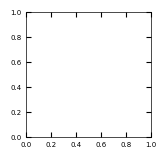

In [38]:
from m3_learning.viz.layout import layout_fig, inset_connector, add_box, subfigures, add_text_to_figure, get_axis_pos_inches, imagemap,  FigDimConverter, labelfigs, imagemap, scalebar

fig, axs = subfigures(1,1, size = (1.25,1.25))


axs.plot(V, proj_nd_shifted_transposed[i[0], i[1], :, 3],'og',
         label='initial loops')
axs.plot(V, loop_fit_results[:, i[0], i[1]], 'blue', label='fit results (NumPy)')
axs.plot(V, np.reshape(loop_fitting_function_tf(func_type, V, params), 
                       (num_pix_1d, num_pix_1d, 96))[i[0], i[1], :], 'black', 
         label='fit results (Tensorflow)')
axs.legend()
axs.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axs.set(xlabel='Voltage (V)', ylabel='Amplitude (Arb. U.)')
axs.label_outer()

(60, 60, 4, 9)

In [ ]:
with h5py.File(dataset.file, "r+") as h5_f:
    
    out = h5_f['/Raw_Data_SHO_Fit/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000/Fit'][:]

In [ ]:
dataset.num_cols

In [ ]:
parm = dataset.LSQF_hysteresis_params(output_shape = "index")

In [ ]:
parm.shape


In [ ]:
out, bias = dataset.get_hysteresis("/Raw_Data_SHO_Fit/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000", plotting_values=True)
out.shape

In [76]:
import matplotlib.pyplot as plt

self = dataset

col = np.random.randint(0, self.num_cols, 1)
cycle = pos = np.random.randint(0, 4, 1)
row = 20

parm = dataset.LSQF_hysteresis_params()[row, col, cycle].view('<f4')
loop = loop_fitting_function_torch(bias[:, cycle], parm, type='9 parameters')
out, bias = dataset.get_hysteresis("/Raw_Data_SHO_Fit/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000", plotting_values=True)



plt.plot(bias[:, cycle].squeeze(), loop.cpu().squeeze(), 'r')
plt.plot(bias[:, cycle].squeeze(), out[row, col, :, cycle].squeeze(), 'b')

type: name 'loop_fitting_function_torch' is not defined

In [ ]:
from scipy.special import erf, erfinv
import warnings

def loop_fit_function(vdc, coef_vec):
    """
    9 parameter fit function
    
    Parameters
    -----------
    vdc : 1D numpy array or list
        DC voltages
    coef_vec : 1D numpy array or list
        9 parameter coefficient vector
        
    Returns
    ---------
    loop_eval : 1D numpy array
        Loop values
    """

    a = coef_vec[:5]
    b = coef_vec[5:]
    d = 1000

    v1 = np.asarray(vdc[:int(len(vdc) / 2)])
    v2 = np.asarray(vdc[int(len(vdc) / 2):])

    g1 = (b[1] - b[0]) / 2 * (erf((v1 - a[2]) * d) + 1) + b[0]
    g2 = (b[3] - b[2]) / 2 * (erf((v2 - a[3]) * d) + 1) + b[2]

    y1 = (g1 * erf((v1 - a[2]) / g1) + b[0]) / (b[0] + b[1])
    y2 = (g2 * erf((v2 - a[3]) / g2) + b[2]) / (b[2] + b[3])

    f1 = a[0] + a[1] * y1 + a[4] * v1
    f2 = a[0] + a[1] * y2 + a[4] * v2

    loop_eval = np.hstack((f1, f2))
    return loop_eval

In [ ]:
plt.plot(bias[:,0])

In [ ]:
loop_eval = loop_fit_function(bias[:,0], parm)

In [ ]:
plt.plot(bias[:,cycle].squeeze(), loop_eval)

In [ ]:
dataset.LSQF_hysteresis_params()[0,0]

In [ ]:
from m3_learning.be.loop_fitter import loop_fitting_function_torch

In [ ]:
with h5py.File("/home/ferroelectric/m3_learning/m3_learning/papers/2023_Rapid_Fitting/Data/data_raw_SHO.h5", "r+") as h5_f:
    # number of pixels in the image
    num_pix = h5_f["Measurement_000"].attrs["num_pix"]
    
    # voltage vector
    V = np.swapaxes(np.atleast_2d(h5_f['Measurement_000']['Channel_000']['UDVS'][::2][:, 1][24:120]), 0, 1).astype(np.float64)
    
    params = np.array(h5_f['Fit_Loop_Parameters'][:])
    

In [ ]:
dataset.dataset

In [ ]:
import matplotlib.pyplot as plt

plt.plot(dataset.hysteresis_waveform)


In [ ]:
# # Sets path to file
# path = r"./"

# # Opens the data file2
# h5_f = h5py.File(path + "data_file.h5", "r+")


# # number of pixels in the image
# num_pix = h5_f["Measurement_000"].attrs["num_pix"]
# #dataset.num_pix

# num_pix_1d = int(np.sqrt(num_pix))
# #dataset.num_pix


# # number of DC voltage steps
# voltage_steps = h5_f["Measurement_000"].attrs["num_udvs_steps"]

# proj_nd_shifted = loop_lsqf(h5_f)
# proj_nd_shifted_transposed = np.transpose(proj_nd_shifted,(1,0,2,3))

# getting parameters for the hysteresis loops
params = np.array(h5_f['params_hysteresis'][:])
params_names = ['a_0', 'a_1', 'a_2', 'a_3', 'a_4', 'b_0', 'b_1', 'b_2', 'b_3']

# voltage vector
V = np.swapaxes(np.atleast_2d(h5_f['Measurement_000']['Channel_000']['UDVS'][::2][:, 1][24:120]), 0, 1).astype(np.float64)

# to set up a type of loop_fitting function to use. Possible options: ['9 parameters', '13 parameters']
func_type = '9 parameters'

# retrieve results
real_loops = np.array(h5_f['real_loops_hysteresis'][:])
unscaled_param_trust = np.array(h5_f['predictions_hysteresis_trustregcg'][:])
unscaled_param_adam = np.array(h5_f['predictions_hysteresis_adam'][:])